# Intro
ResNet34 to predict the presence of Dementia alterations

http://arxiv.org/pdf/1603.05027v2.pdf

# Setup

In [6]:
import keras
import six
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv3D,
    MaxPooling3D,
    AveragePooling3D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras import initializers
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

# Load images

In [2]:
X=[]                               #images
y=[]                               #labels

data_dir = 'Documents/projet_final/project/data/sample/AD-numpyArr'

for file in os.listdir(data_dir):
    data=np.load(os.path.join(data_dir,file),allow_pickle=True)
    X.append((data[0][0]))
    y.append(data[0][1])

data_dir = 'Documents/projet_final/project/data/sample/MCI-numpyArr'

for file in os.listdir(data_dir):
    data=np.load(os.path.join(data_dir,file),allow_pickle=True)
    X.append((data[0][0]))
    y.append(data[0][1])
    
data_dir = 'Documents/projet_final/project/data/sample/CN-numpyArr'

for file in os.listdir(data_dir):
    data=np.load(os.path.join(data_dir,file),allow_pickle=True)
    X.append((data[0][0]))
    y.append(data[0][1])

sh=np.array(X).shape

# Define Resnet Functions

In [3]:
#Function to build a BN -> relu block
def _bn_relu(input):
    
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)

#Function to build a conv -> BN -> relu block
def _conv_bn_relu(**conv_params):
    
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1,1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        print ("filters"+str(filters))
        print ("kernel_size"+str(kernel_size))
        print ("strides"+str(strides))
        print ("padding"+str(padding))
        print ("kernel_initializer"+str(kernel_initializer))
        print ("kernel_regularizer"+str(kernel_regularizer))
        print ("kernel_regularizer"+str(kernel_regularizer))
        conv = Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f

#Function to build a BN -> relu -> conv block.
#This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
def _bn_relu_conv(**conv_params):
    
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1,1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f

#Add a shortcut between input and residual block and merges them with "sum"
def _shortcut(input, residual):
   
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    stride_depth = int(round(input_shape[DEPTH_AXIS] / residual_shape[DEPTH_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or stride_depth>1 or not equal_channels:
        shortcut = Conv3D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1,1),
                          strides=(stride_width, stride_height,stride_depth),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])

#Builds a residual block with repeating bottleneck blocks.
def _residual_block(block_function, filters, repetitions, is_first_layer=False):

    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1,1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2,2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f

#Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
#Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
def basic_block(filters, init_strides=(1, 1,1), is_first_block_of_first_layer=False):
    
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv3D(filters=filters, kernel_size=(3, 3,3),
                           strides=init_strides,
                           padding="same",
#                          kernel_initializer=initializers.RandomNormal(stddev=0.01),
                            kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3,3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3,3))(conv1)
        return _shortcut(input, residual)

    return f

#Bottleneck architecture for > 34 layer resnet.
#Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
#Returns:A final conv layer of filters * 4
def bottleneck(filters, init_strides=(1, 1,1), is_first_block_of_first_layer=False):

    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv3D(filters=filters, kernel_size=(1, 1,1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1,1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3,3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1,1))(conv_3_3)
        return _shortcut(input, residual)

    return f

#Function for ordering the dimensions (mandatory for incompatibility between keras and tensorflow)
#Use tensorflow as backend
def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global DEPTH_AXIS
    global CHANNEL_AXIS
    if K.common.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        DEPTH_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3
        DEPTH_AXIS = 4


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier
    
#Resnet builder class
class ResnetBuilder(object):
    @staticmethod
    
    
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 4:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        
        # Permute dimension order if necessary
        if K.common.image_dim_ordering() == 'tf':
            
             input_shape = (input_shape[1], input_shape[2],input_shape[3], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7,7), strides=(2, 2,2))(input)
        pool1 = MaxPooling3D(pool_size=(3, 3,3), strides=(2, 2,2), padding="same")(conv1)


        block = pool1
        filters = 64

        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)
        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling3D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS],block_shape[DEPTH_AXIS]),
                                 strides=(1, 1,1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense, name = 'resnet34')
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

model=ResnetBuilder.build_resnet_34((1,21,42,42),3)
              
model.compile('Adam','categorical_crossentropy',metrics=['accuracy'])

filters64
kernel_size(7, 7, 7)
strides(2, 2, 2)
paddingsame
kernel_initializerhe_normal
kernel_regularizer<keras.regularizers.L1L2 object at 0x000001C241F95C48>
kernel_regularizer<keras.regularizers.L1L2 object at 0x000001C241F95C48>


In [4]:
model.summary()

Model: "resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 21, 42, 42, 1 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 11, 21, 21, 6 22016       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 11, 21, 21, 6 256         conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 11, 21, 21, 6 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

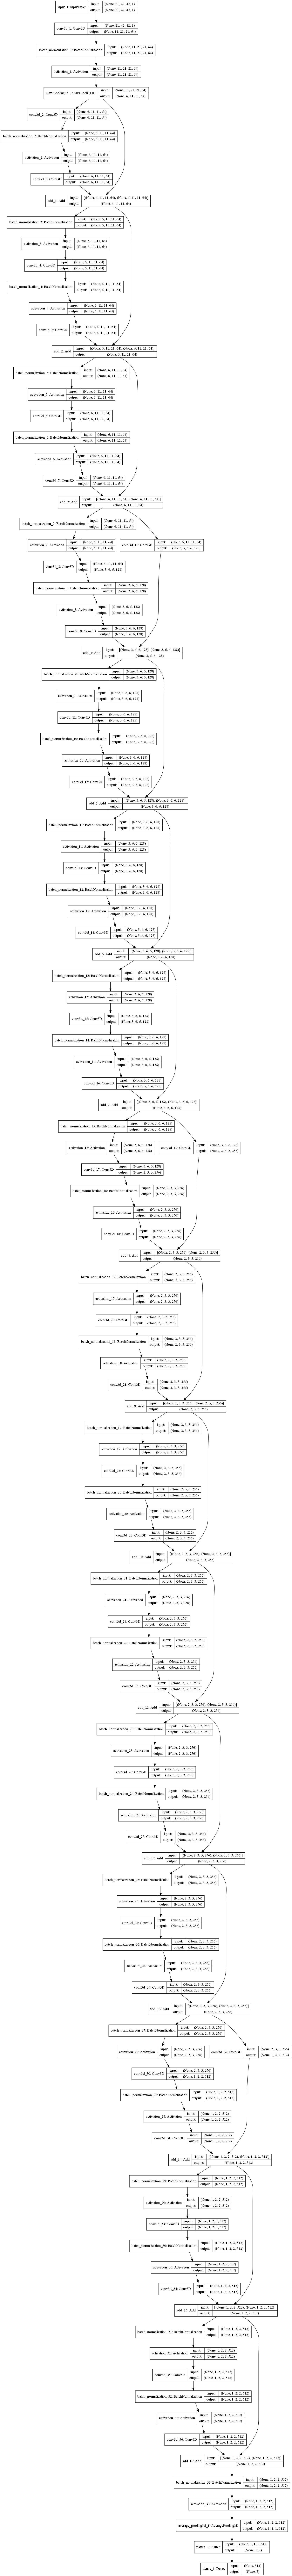

In [29]:
plot_model(model, to_file='../models/resnet_arch.png', show_shapes=True)

# Split dataset and labels 80/20

In [3]:
X = np.array(X)
y = np.array(y)

# Split
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train= np.array(X_train)
X_train = np.expand_dims(X_train, axis=4)

X_test= np.array(X_test)
X_test = np.expand_dims(X_test, axis=4)

print("Number of samples in train and validation are %d and %d." % (X_train.shape[0], x_val.shape[0]))

Number of samples in train and validation are 244 and 62.


In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(244, 21, 42, 42, 1)
(244, 3)
(62, 21, 42, 42, 1)
(62, 3)


In [5]:
X_train

array([[[[[-0.02668243],
          [-0.02668243],
          [-0.02668243],
          ...,
          [-0.02668243],
          [-0.02668243],
          [-0.02668243]],

         [[-0.02668243],
          [-0.02668243],
          [-0.02668243],
          ...,
          [-0.02668243],
          [-0.02668243],
          [-0.02668243]],

         [[-0.02668243],
          [-0.02668243],
          [-0.02668243],
          ...,
          [-0.02668243],
          [-0.02668243],
          [-0.02668243]],

         ...,

         [[-0.02668243],
          [-0.02668243],
          [-0.02668243],
          ...,
          [-0.02668243],
          [-0.02668243],
          [-0.02668243]],

         [[-0.02668243],
          [-0.02668243],
          [-0.02668243],
          ...,
          [-0.02668243],
          [-0.02668243],
          [-0.02668243]],

         [[-0.02668243],
          [-0.02668243],
          [-0.02668243],
          ...,
          [-0.02668243],
          [-0.02668243],
          

# Fit the Model

In [6]:
BS = 8
EPOCHS = 30

n_jobs = -1

# Callbacks
callbacks_list=[]
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, verbose=0,  patience=5, mode='auto', cooldown=0, min_lr=0.0001)
callbacks_list.append(reduce_lr)


H = model.fit(
    X_train, y_train,
    batch_size=BS,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list,
    validation_data = (X_test, y_test),
    shuffle = False,
    class_weight=None,
    initial_epoch=0)

print(H.history.keys())
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 244 samples, validate on 62 samples
Epoch 1/30
244/244 [==============================] - 89s 363ms/step - loss: 2.6888 - accuracy: 0.4303 - val_loss: 12.4954 - val_accuracy: 0.3710
Epoch 2/30
244/244 [==============================] - 76s 310ms/step - loss: 2.3492 - accuracy: 0.4098 - val_loss: 2.3436 - val_accuracy: 0.3710
Epoch 3/30
244/244 [==============================] - 77s 315ms/step - loss: 2.1811 - accuracy: 0.4467 - val_loss: 2.1675 - val_accuracy: 0.3710
Epoch 4/30
244/244 [==============================] - 78s 319ms/step - loss: 2.0520 - accuracy: 0.4713 - val_loss: 2.0565 - val_accuracy: 0.3710
Epoch 5/30
244/244 [==============================] - 78s 321ms/step - loss: 1.9674 - accuracy: 0.4713 - val_loss: 1.9620 - val_accuracy: 0.3548
Epoch 6/30
244/244 [==============================] - 91s 372ms/step - loss: 1.8104 - accuracy: 0.5615 - val_loss: 1.8868 - val_accuracy: 0.4516
Epoch 7/30
244/244 [==============================] - 88s 359ms/step - loss: 1.6733 

NameError: name 'plt' is not defined

# Visualize model performance

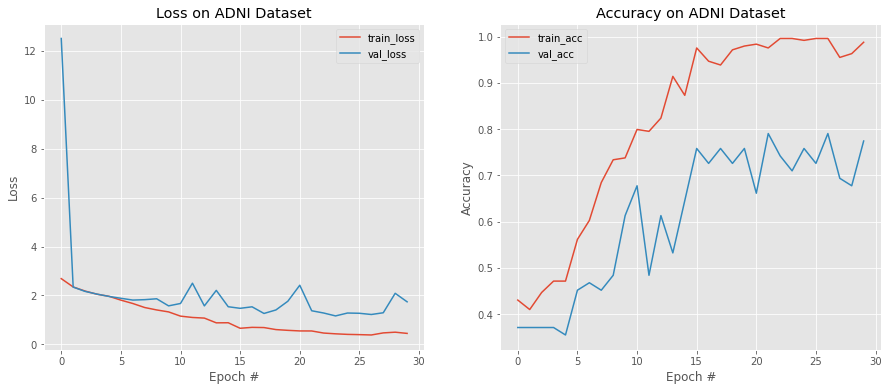

In [7]:
N = EPOCHS
plt.figure(figsize=(15, 6))
plt.style.use("ggplot")
plt.subplot(1, 2, 1)
#fig, ax = plt.subplots(1,2,figsize=(12,6),xlabel="Epoch #")
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Loss on ADNI Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy on ADNI Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Prediction

In [11]:
prediction = model.predict(X_test)
print(np.argmax(prediction, axis=1))

[0 2 2 2 2 2 0 2 0 2 0 0 0 0 0 0 0 1 0 0 2 2 0 2 2 2 2 0 1 1 0 2 0 0 2 0 0
 2 0 2 0 2 0 0 2 2 2 2 2 0 2 1 0 1 1 0 2 0 0 0 2 0]


In [12]:
np.array(y_test).argmax(axis=1)

array([1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2,
       0, 2, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0, 2, 2, 0, 2, 0, 1, 0, 2, 0, 0,
       1, 1, 2, 0, 2, 0, 2, 1, 0, 1, 2, 0, 0, 0, 0, 2, 2, 0], dtype=int64)

## Confusion Matrix & Accuracy

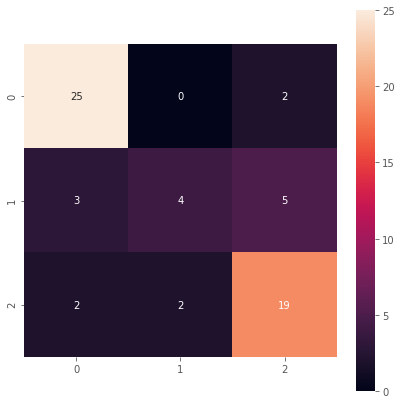

Accuracy: 0.7741935483870968


In [13]:
y_train_class = np.array(y_test).argmax(axis=1)
y_pred_class = np.argmax(prediction, axis=1)
conf_mat = confusion_matrix(y_train_class, y_pred_class)
plt.figure(figsize=(7,7))
sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f')
plt.show()
print('Accuracy:',accuracy_score(y_train_class, y_pred_class))

In [47]:
X_test= np.array(X_test)
X_test = np.expand_dims(X_test, axis=4)

In [18]:
from tqdm import tqdm

tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(X_test)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


In [20]:
from sklearn import preprocessing
predIdxs = np.argmax(pred, axis=1)
lb = preprocessing.LabelBinarizer()
lb.fit_transform(truenp_temp)

predIdxs

array([0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2,
       0, 2, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0,
       2, 2, 2, 2, 2, 0, 2, 1, 0, 1, 1, 0, 2, 0, 0, 0, 2, 0], dtype=int64)

In [21]:
np.argmax(pred, axis=1)

array([0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2,
       0, 2, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0,
       2, 2, 2, 2, 2, 0, 2, 1, 0, 1, 1, 0, 2, 0, 0, 0, 2, 0], dtype=int64)

In [22]:
score = model.evaluate(X_test, pred)

print("test loss, test acc:", score)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test)
print("predictions shape:", predictions.shape)

62/62 [==============================] - 3s 43ms/step
test loss, test acc: [0.5188003586184594, 1.0]
Generate predictions for 3 samples
predictions shape: (62, 3)


In [52]:
'''----------  0 = MCI  ----------  1 = AD ---------- 2 = CN -----------'''

'----------  0 = MCI  ----------  1 = AD ---------- 2 = CN -----------'

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] +cm[2,2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[25  0  2]
 [ 3  4  5]
 [ 2  2 19]]
acc: 0.7742
sensitivity: 1.0000
specificity: 0.5714


## Others metrics

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), predIdxs, target_names = ["MCI","AD","CN"]))

              precision    recall  f1-score   support

         MCI       0.83      0.93      0.88        27
          AD       0.67      0.33      0.44        12
          CN       0.73      0.83      0.78        23

    accuracy                           0.77        62
   macro avg       0.74      0.70      0.70        62
weighted avg       0.76      0.77      0.76        62



# Save the model

In [27]:
model.save_weights("../models/resnet_model.h5")
print ("saving model to disk..")

saving model to disk..
